## Task 4 — Data Reduction (15 points)

In this task, we reduce the size of the training dataset (originally ~62 MB zipped) while preserving classification performance. The objective is to produce reduced versions targeting 50%, 25%, and 10% of the original size.

Our reduction pipeline includes:
- **Fourier Transform**: Keeps only the top energy frequencies (`compress_fourier`)
- **Piecewise Linear Approximation (PLA)**: Removes redundant values based on a maximum error threshold (`compress_pla`)
- **Custom serialization**: Writes compressed signals to `.bin` files compatible with the original parser

The following parameter combinations were used (obtained mostly via trial and error):
- **50%**: `keep_ratio = 0.03`, `max_error = 15.0`
- **25%**: `keep_ratio = 0.01`, `max_error = 22.0`
- **10%**: `keep_ratio = 0.003`, `max_error = 35.0`

* Assuming the original data resides in the folder called `data` located at the parent directory w.r.t. this notebook, the reduced training data files also will be located under that file.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
from scipy.fftpack import fft, ifft

def compress_fourier(signal: np.ndarray, keep_ratio: float = 0.05) -> np.ndarray:
    """
    the main idea of this function is basically lossy compression of signals
    using FT with thresholding
    - transform signals into freq domain using FFT
    - keep freq components which has highest magnitudes and zero the rest (thresholding)
    - transform signals back into time domain using inverse FFT
    """
    coeffs = fft(signal)    # apply fft to signal
    magnitude = np.abs(coeffs)  
    threshold = np.quantile(magnitude, 1 - keep_ratio)  # keep only *keep ratio* amount of signals (w.r.t. magnitudes)
    coeffs[magnitude < threshold] = 0   # masking (thresholding)
    return np.real(ifft(coeffs)).astype(np.int16)   # back into time domain using IFFT (we only need real part)

def compress_pla(signal: np.ndarray, max_error: float = 10.0) -> np.ndarray:
    """
    apply piecewise linear approximation
    reduce the number of points in the signal by removing small fluctuations
    max_error : maximum allowed difference between consecutive retained values If a new point does not 
    differ from the last one by more than this value, it gets discarded
    """

    # algorithm works similar to sliding window technique
    if len(signal) == 0:
        return signal
    output = [signal[0]]
    last = signal[0]
    for x in signal[1:]:
        if abs(x - last) > max_error:
            output.append(x)
            last = x
    return np.array(output, dtype=np.int16)


In [3]:
import struct
import zipfile
from src.parser import read_zip_binary


def write_reduced_bin(signals: list, out_bin_path: str):
    """
    write a list of reduced signals (as np arrays) into a single binary .bin file
    uses the same structure as the original training data
    """
    with open(out_bin_path, "wb") as f:
        for signal in signals:
            f.write(struct.pack("i", len(signal)))
            f.write(signal.tobytes())

def create_reduced_zip(input_zip: str, output_zip: str, keep_ratio: float = 0.05, max_error: float = 10.0):
    """
    basically the main function that compresses the data w.r.t. above logic and create
    corresponding zip files

    - load signals from the original zip
    - compress each signal using fourier and pla
    - write the reduced signals to a binary (.bin) file,
    - zip the .bin file
    """
    # load original data
    print(f"Reading original data from {input_zip}...")
    print(f"Initial file size: {round(os.path.getsize(input_zip) / (1024 * 1024),1)} MBs.")
    signals = read_zip_binary(input_zip)

    # apply compression
    print("Applying Fourier + PLA compression... (wait)")
    reduced_signals = []
    for signal in signals:
        s1 = compress_fourier(signal, keep_ratio=keep_ratio)
        s2 = compress_pla(s1, max_error=max_error)
        reduced_signals.append(s2)

    # write reduced data to binary (.bin) file
    bin_name = os.path.splitext(os.path.basename(output_zip))[0] + '.bin'
    temp_bin_path = f"./{bin_name}"
    write_reduced_bin(reduced_signals, temp_bin_path)

    # zip the bin file
    print(f"Zipping to {output_zip}...")
    with zipfile.ZipFile(output_zip, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        zf.write(temp_bin_path, arcname=bin_name)

    os.remove(temp_bin_path)
    print(f"Done. Final size: {round(os.path.getsize(output_zip) / (1024 * 1024),1)} MBs. \n")


In [4]:
# input path (original)
input_zip = "../data/X_train.zip"

# target file paths (reduced)
output_zip_10 = "../data/X_train_reduced_10.zip"
output_zip_25 = "../data/X_train_reduced_25.zip"
output_zip_50 = "../data/X_train_reduced_50.zip"

# below is the main part of the compression that uses below logic
# and here we control the compression/reduction strength

# reduce to 10 percent
create_reduced_zip(input_zip, output_zip_10, keep_ratio=0.003, max_error=35.0)

# reduce to 25 percent
create_reduced_zip(input_zip, output_zip_25, keep_ratio=0.01, max_error=22.0)

# reduce to 50 percent
create_reduced_zip(input_zip, output_zip_50, keep_ratio=0.03, max_error=15.0)


Reading original data from ../data/X_train.zip...
Initial file size: 61.2 MBs.
Applying Fourier + PLA compression... (wait)
Zipping to ../data/X_train_reduced_10.zip...
Done. Final size: 6.2 MBs. 

Reading original data from ../data/X_train.zip...
Initial file size: 61.2 MBs.
Applying Fourier + PLA compression... (wait)
Zipping to ../data/X_train_reduced_25.zip...
Done. Final size: 15.9 MBs. 

Reading original data from ../data/X_train.zip...
Initial file size: 61.2 MBs.
Applying Fourier + PLA compression... (wait)
Zipping to ../data/X_train_reduced_50.zip...
Done. Final size: 30.2 MBs. 



In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load training labels
y_train = pd.read_csv("../data/y_train.csv", header=None)
y_train.columns = ["y"]

def save_stratified_indices(y_train, prefix="stratified_subset", fractions=[0.1, 0.25, 0.5]):   # prefix ~path name
    """
    idea is basically creating subset of training data (10% 25% 50%)
    instead of creating additional zip folders of training data we
    sample through training labels (y) and save the corresponding indices
    into a .npy file. for further use, we can simply use advanced indexing
    functionality of numpy (just as in 01_data_exploration notebook)
    """
    y_train = np.array(y_train)
    all_indices = np.arange(len(y_train))  # 0 to len-1

    for frac in fractions:
        strat_indices, _ = train_test_split(
            all_indices,
            train_size=frac,
            stratify=y_train,
            random_state=1  # assign random state for reproducability
        )
        filename = f"{prefix}_{int(frac * 100)}.npy"    # indices will reside in .npy files
        np.save(filename, strat_indices)
        print(f"Saved {len(strat_indices)} samples ({frac*100:.0f}%) to {filename}")

save_stratified_indices(y_train, prefix="../data/stratified_subset")

# later on those indices in npy files will be used for performance comparison between
# reduced datasets and stratified subsamples

Saved 617 samples (10%) to ../data/stratified_subset_10.npy
Saved 1544 samples (25%) to ../data/stratified_subset_25.npy
Saved 3089 samples (50%) to ../data/stratified_subset_50.npy


In [6]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.parser import read_zip_binary
from src.train import train_model
from src.ecg_dataset import ECGDataset, ECGTestDataset, prep_batch, prep_batch_noisy_shifting, prep_test_batch
from src.stft_featured import BaselineSTFTFeaturedModel
from sklearn.utils.class_weight import compute_class_weight
from src.split import create_stratified_split
from src.time_warp import time_compress_stretch

# Load labels once
y_orig = pd.read_csv("../data/y_train.csv", header=None, names=["y"])

# test data
X_test = read_zip_binary("../data/X_test.zip")
test_dataset = ECGTestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=prep_test_batch)


# Define only the compressed datasets to evaluate
dataset_configs = {
    "reduced_10": "../data/X_train_reduced_10.zip",
    "reduced_25": "../data/X_train_reduced_25.zip",
    "reduced_50": "../data/X_train_reduced_50.zip"
}

# Common hyperparameters
rates      = [0.8, 0.9, 1.1, 1.2]
batch_size = 16
val_batch  = 32
device     = "cpu"
num_epochs = 50
lr         = 5e-4
wd         = 1e-4

results = {}

for label, zip_path in dataset_configs.items():
    print(f"\n=== Training on dataset: {label} ({zip_path}) ===")
    # Read reduced signals
    X_orig = read_zip_binary(zip_path)
    
    # Stratified split
    train_idx, val_idx = create_stratified_split(X_orig, y_orig, val_size=0.2, seed=343)

    # Build train set: original + time‑warp augment
    X_train_base = [X_orig[i] for i in train_idx]
    y_train_base = y_orig.iloc[train_idx].reset_index(drop=True)
    X_train_aug  = [time_compress_stretch(s, rate=np.random.choice(rates)) for s in X_train_base]
    X_train_all  = X_train_base + X_train_aug
    y_train_all  = pd.concat([y_train_base, y_train_base], ignore_index=True)

    # Build validation set: only originals
    X_val = [X_orig[i] for i in val_idx]
    y_val = y_orig.iloc[val_idx].reset_index(drop=True)

    # Create datasets & loaders
    train_ds = ECGDataset(X_train_all, y_train_all)
    val_ds   = ECGDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              collate_fn=prep_batch_noisy_shifting)
    val_loader   = DataLoader(val_ds,   batch_size=val_batch, shuffle=False,
                              collate_fn=prep_batch)

    # Initialize model, loss, optimizer
    model = BaselineSTFTFeaturedModel().to(device)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_all["y"]),
        y=y_train_all["y"]
    )
    loss_fn = torch.nn.CrossEntropyLoss(
        weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Train & record history
    model, history = train_model(
        model, train_loader, val_loader,
        optimizer, loss_fn, device, num_epochs=num_epochs,
        verbose=True
    )
    results[label] = history

    if label == "reduced_25":
        save_name = f"../models/stft_model_{label}.pt"
        # Ensure parent directory exists before saving
        os.makedirs(os.path.dirname(save_name), exist_ok=True)
        torch.save(model.state_dict(), save_name)
        print(f"Saved model for {label} at: {save_name}")


=== Training on dataset: reduced_10 (../data/X_train_reduced_10.zip) ===
Epoch 01 | Time: 16.9s
  Train Loss: 1.3900 | Acc: 0.3599 | F1: 0.2576
  Val   Loss: 1.2821 | Acc: 0.4029 | F1: 0.3315
Epoch 02 | Time: 19.6s
  Train Loss: 1.3315 | Acc: 0.3547 | F1: 0.2760
  Val   Loss: 1.2006 | Acc: 0.2079 | F1: 0.2239
Epoch 03 | Time: 19.2s
  Train Loss: 1.2789 | Acc: 0.3626 | F1: 0.2984
  Val   Loss: 1.1774 | Acc: 0.3803 | F1: 0.3347
Epoch 04 | Time: 17.3s
  Train Loss: 1.2672 | Acc: 0.3544 | F1: 0.2952
  Val   Loss: 1.1642 | Acc: 0.2945 | F1: 0.2464
Epoch 05 | Time: 18.5s
  Train Loss: 1.2592 | Acc: 0.3540 | F1: 0.2994
  Val   Loss: 1.1785 | Acc: 0.4417 | F1: 0.3484
Epoch 06 | Time: 17.8s
  Train Loss: 1.2553 | Acc: 0.3449 | F1: 0.2974
  Val   Loss: 1.1638 | Acc: 0.3940 | F1: 0.3192
Epoch 07 | Time: 15.1s
  Train Loss: 1.2490 | Acc: 0.3476 | F1: 0.3015
  Val   Loss: 1.1518 | Acc: 0.4482 | F1: 0.3377
Epoch 08 | Time: 18.1s
  Train Loss: 1.2539 | Acc: 0.3652 | F1: 0.3065
  Val   Loss: 1.1515 |

In [7]:
# generate reduced.csv on reduced_25 model

# inference
model = BaselineSTFTFeaturedModel()

model.load_state_dict(torch.load("../models/stft_model_reduced_25.pt"))
model.eval()  # inference mode

X_test = read_zip_binary("../data/X_test.zip")
test_dataset = ECGTestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=prep_test_batch)

# inference
predictions = []
with torch.no_grad():
    for signals, lengths in test_loader:
        signals = [s.to(device) for s in signals]
        outputs = model(signals, lengths)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

# save to csv file
pd.DataFrame(predictions).to_csv("../csvs/reduced.csv", index=False, header=False)

/var/folders/m7/6q2g6mps7ss5359kk2xm5b3r0000gn/T/ipykernel_94678/2691905742.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/s

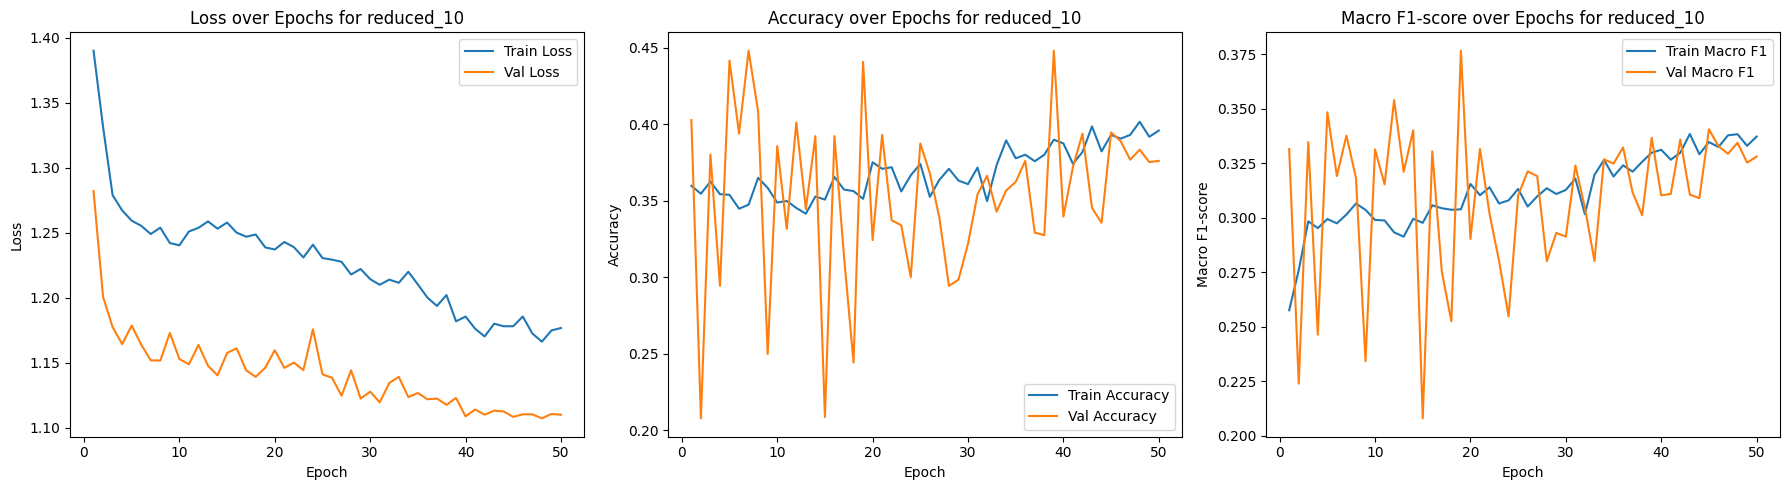

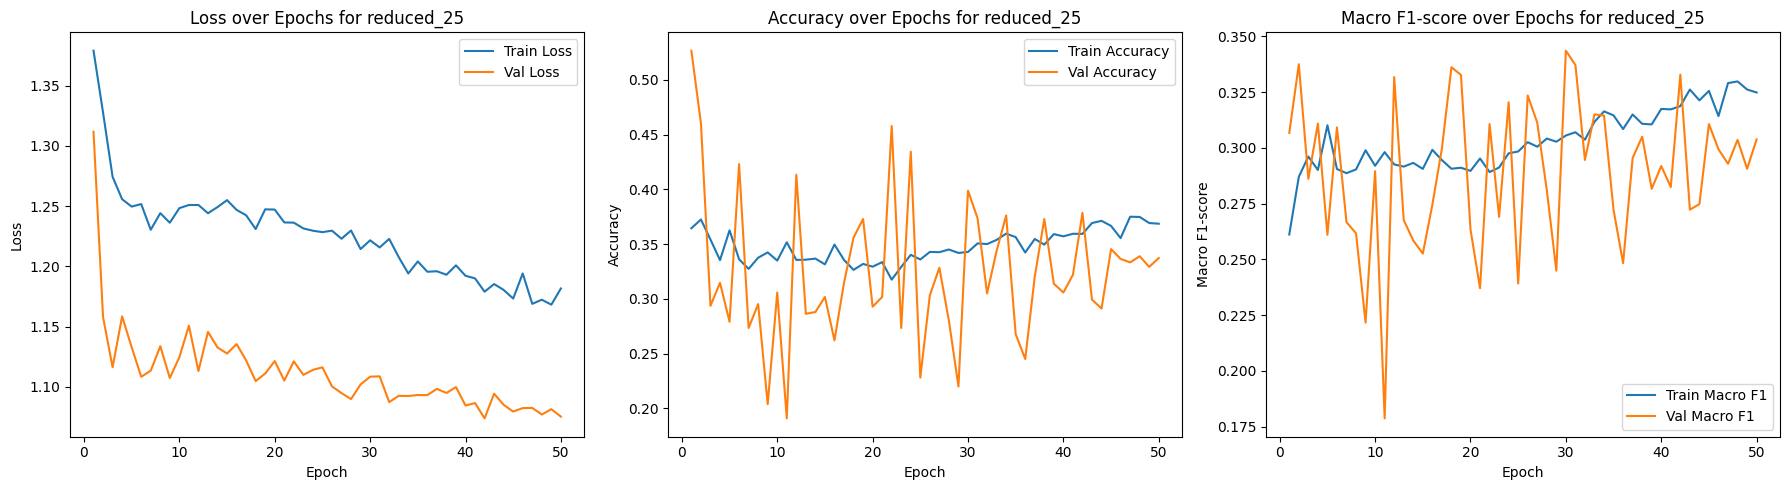

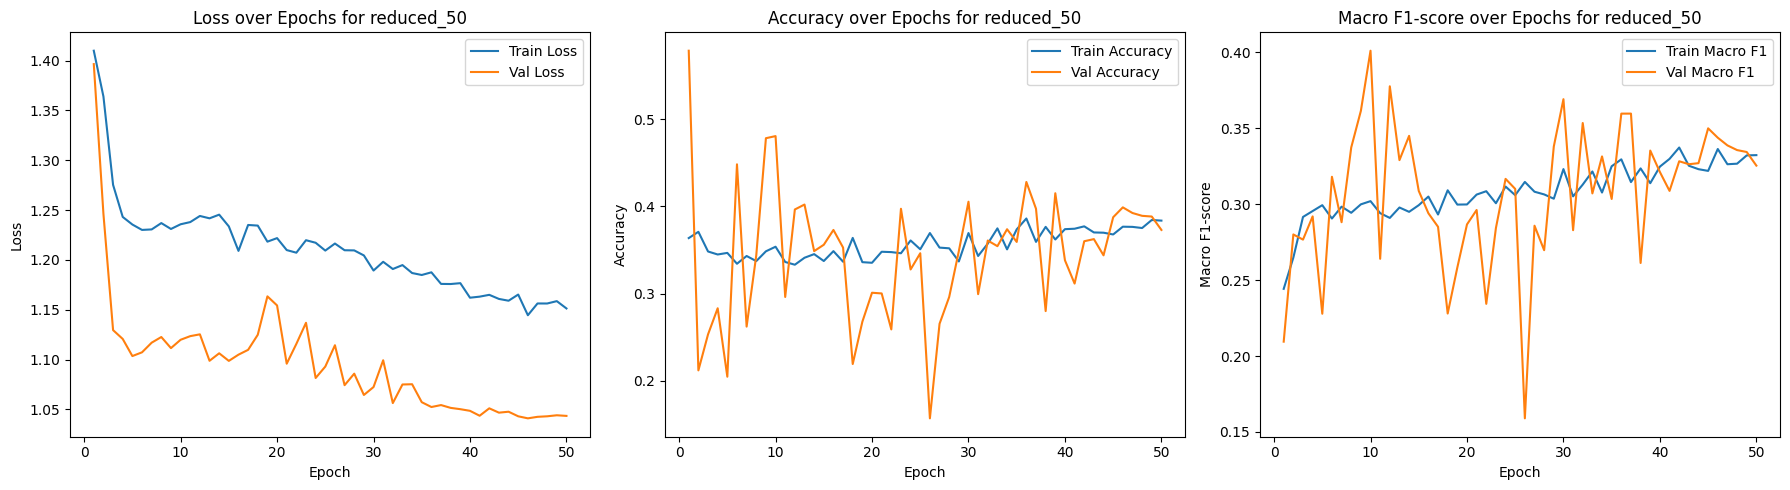

In [10]:
# generate line plots for varying data sizes

import matplotlib.pyplot as plt
import numpy as np

def plot_history(history, label):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss over Epochs for {label}")
    plt.legend()

    # accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy over Epochs for {label}")
    plt.legend()

    # f1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_f1"], label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1-score")
    plt.title(f"Macro F1-score over Epochs for {label}")
    plt.legend()

    plt.tight_layout()
    plt.show()

for label, history in results.items():
    plot_history(history, label)